## 数据采集
* py连接sql数据库
* sql server数据库取数
* 数据为公司17-18年2月客户LRFM数据

In [253]:
##导入数据
import pymssql
import pandas as pd
conn = pymssql.connect(host='172.16.1.23',user='WYFX',password='yht!%(#%&',database='med1004',port=1433,charset='utf8')
SQL='''select MEMBER_id,datediff(dd,createtime,getdate())L,datediff(dd,lastsalestime,getdate())R,F,M from med1004..Member
inner join 
(select MEMBER_id ,count(*) F ,SUM(salesmoney)M
from (SELECT * from med1004..Membersales where Salesmoney!=0) T1
group by MEMBER_id) T2
on Member.ID=T2.MEMBER_id'''
data=pd.read_sql(SQL,conn)
conn.close()

In [24]:
#看下数据
data=data.set_index('MEMBER_id')
data.head()

,L,R,F,M
MEMBER_id,,,,
13852,517,171,2,99.2
13935,517,9,10,490.6
14171,517,199,2,314.8
14186,517,291,2,127.8
14286,517,32,9,290.2


# 数据清洗

## 数据标准化
这里使用sklearn中的StandardScaler方法

In [25]:
from sklearn.preprocessing import StandardScaler
data=pd.DataFrame(StandardScaler().fit(data).transform(data)).rename(columns={0:'L',1:'R',2:'F',3:'M'})
data.head()

,L,R,F,M
0,2.027992,0.597998,-0.241471,-0.199582
1,2.027992,-1.048059,1.558620,-0.007990
2,2.027992,0.882502,-0.241471,-0.094045
3,2.027992,1.817299,-0.241471,-0.185582
4,2.027992,-0.814359,1.333609,-0.106086


In [60]:
#引入画图的包
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

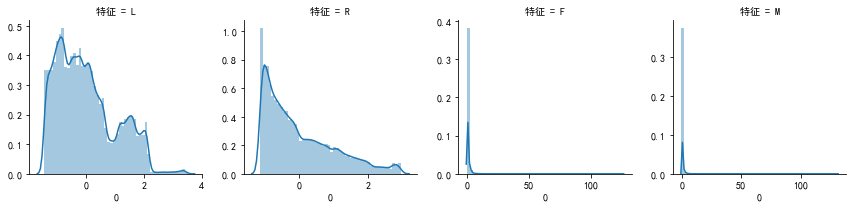

In [16]:
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
sns.FacetGrid(data.stack().reset_index().rename(columns={'level_1':'特征'}),col='特征',sharex=False,sharey=False).map(sns.distplot,0)

* 经过数据标准化后可以发现,F和M分布比较靠前,说明离散点数量多
* 这里的离散点数据可能是批发等渠道,也有可能是超级会员,需求量比较大,这里不作聚类研究,故对F和M数据进行处理(高于98分位数的数用98分位数替换)

In [26]:
import numpy as np
def 离散点替换(data,x):
    data.loc[data[x]>=np.percentile(data[x],98),x]=np.percentile(data[x],98)
离散点替换(data,'F')
离散点替换(data,'M')

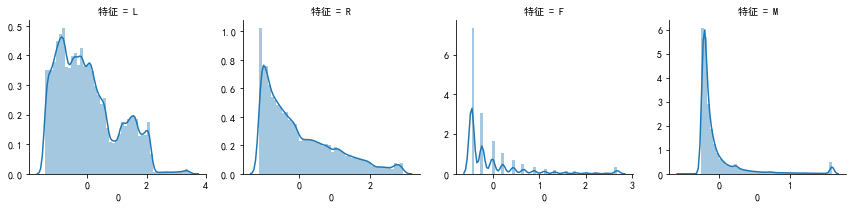

In [27]:
sns.FacetGrid(data.stack().reset_index().rename(columns={'level_1':'特征'}),col='特征',sharex=False,sharey=False).map(sns.distplot,0)

* 虽然也不是很理想,但是表现好很多

# 建模聚类分析
### 从实际业务出发,将客户价值为为五类:

In [28]:
#模型训练
from sklearn.cluster import KMeans
Kmodol=KMeans(5,n_jobs=4)
Kmodol.fit(data)
data['类别']=Kmodol.labels_
data=data.rename(columns={0:'L',1:'R',2:'F',3:'M'})
data.head()

,L,R,F,M,类别
0,2.027992,0.597998,-0.241471,-0.199582,3
1,2.027992,-1.048059,1.558620,-0.007990,2
2,2.027992,0.882502,-0.241471,-0.094045,4
3,2.027992,1.817299,-0.241471,-0.185582,4
4,2.027992,-0.814359,1.333609,-0.106086,2


* 数据聚类完毕

# 可视化分析

## 各聚类各项特征的分布情况

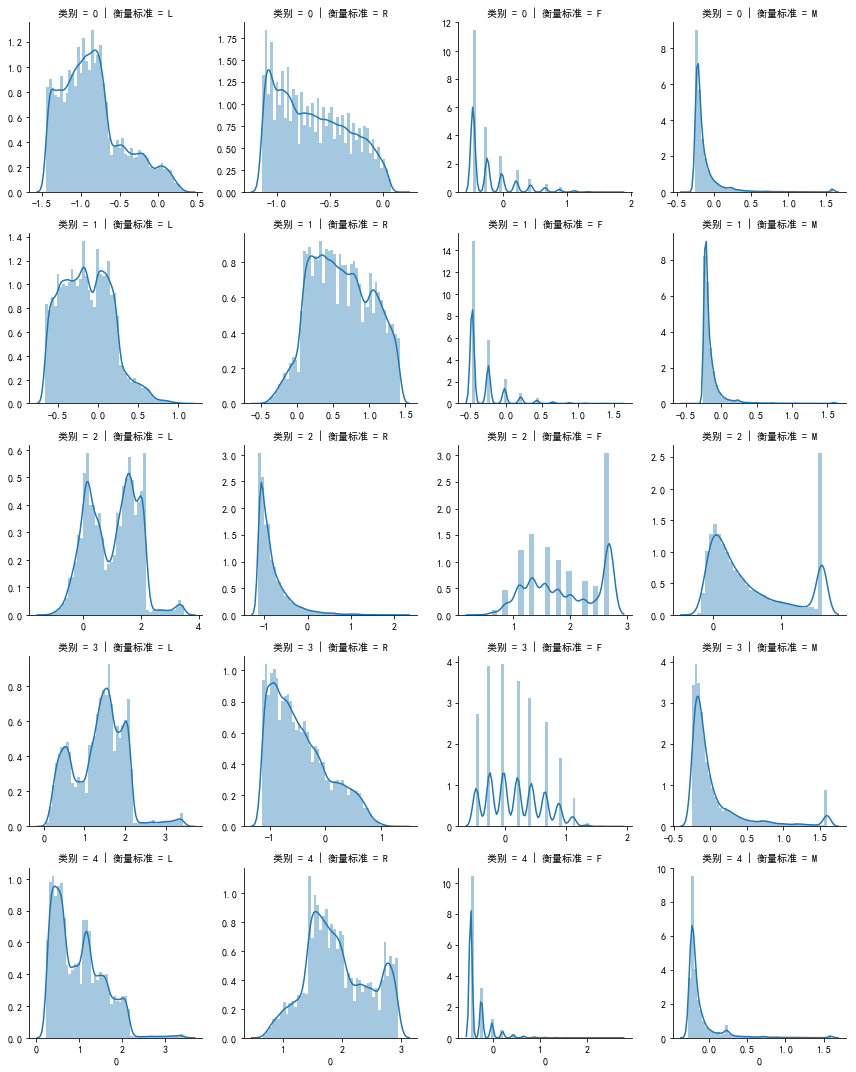

In [29]:
data_X=data.set_index('类别').stack().reset_index().rename(columns={'level_1':'特征'})
g = sns.FacetGrid(data_X, row="类别",col='特征',sharex=False,sharey=False)
g.map(sns.distplot,0)

## 主成分分析
对数据进行降维(二维)来观察每个类别的分布情况

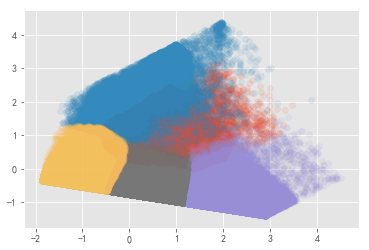

In [248]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
x=['L','R','F','M']
pca.fit(np.array(data[x]))
data_pca=pd.DataFrame(pca.transform(np.array(data[x])))
data_pca['类别']=data.类别
for 类别 in data_pca.类别.unique():
    plt.scatter(data_pca.loc[data_pca.类别==类别,0],data_pca.loc[data_pca.类别==类别,1],alpha=0.1)

较为明显的分成了5个聚类

## 观察5个簇中心点,用来衡量聚类的类型

In [94]:
cluster_centers=pd.DataFrame(Kmodol.cluster_centers_).rename(columns={0:'L',1:'R',2:'F',3:'M'})
data1=pd.concat([cluster_centers,pd.Series(Kmodol.labels_).value_counts()],axis=1).rename(columns={0:'数量'})
data1

,L,R,F,M,数量
0,-0.847303,-0.654517,-0.216930,-0.105230,120154
1,-0.133923,0.610819,-0.310375,-0.146048,68472
2,1.003945,-0.812075,1.902313,0.530987,21351
3,1.360289,-0.456422,0.174226,0.059832,38602
4,0.993729,1.927287,-0.329567,-0.100614,37260


[Text(0,0,'L'), Text(0,0,'R'), Text(0,0,'F'), Text(0,0,'M')]

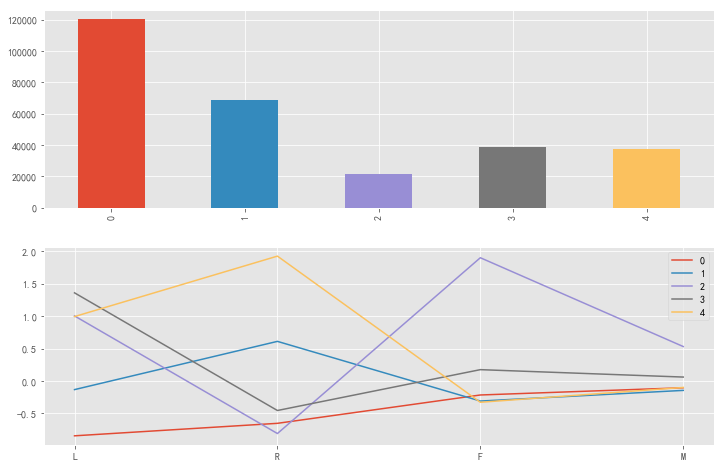

In [256]:
fig=plt.figure(figsize=(12,8))
fig.add_subplot(211)
data1.数量.plot('bar')
fig.add_subplot(212)
for i in data1.drop('数量',axis=1).T.columns:
    plt.plot(np.arange(1,len(data1.drop('数量',axis=1))),data1.drop('数量',axis=1).T[i])
plt.legend()
ax=plt.gca() 
ax.set_xticks(np.arange(1,len(data1.drop('数量',axis=1))))
ax.set_xticklabels(data1.drop('数量',axis=1).columns)

# 客户聚类定义

## 评判标准:
* L =Load_time-ffp_date 会员加入时长  
* R = Recency 最近一次消费　　越低越有价值
* F = Frequency 消费频率　　  越高越有价值
* M = Monetary 消费金额     越高越有价值


## 将用户群依次从价值排序可分为:
* 重要保持会员
* 重要发展会员
* 普通会员
* 需要挽留会员
* 已流失会员
### 分析上图可知:
    1. 客户群2的R最短,且F,M最高,定义为重要保持会员
    2. 客户群0的L(时长)最小,定义为重要发展会员
    3. 客户群3的L(时长)最长,且R较小,定义为普通会员
    4. 客户群1相较其他会员,定义为需要挽留会员
    5. 客户群4的R最长,说明很久没有消费,定义为已流失会员

In [301]:
data_cluster=pd.DataFrame({'index':[2,0,3,1,4],'客户聚类':['重要保持会员','重要发展会员','普通会员','挽留会员','已流失会员']}).set_index('index')
pd.merge(data1,data_cluster,left_index=True,right_index=True)

,L,R,F,M,数量,客户聚类
0,-0.847303,-0.654517,-0.216930,-0.105230,120154,重要发展会员
1,-0.133923,0.610819,-0.310375,-0.146048,68472,挽留会员
2,1.003945,-0.812075,1.902313,0.530987,21351,重要保持会员
3,1.360289,-0.456422,0.174226,0.059832,38602,普通会员
4,0.993729,1.927287,-0.329567,-0.100614,37260,已流失会员


# 模型应用
1. 会员等级:建立良好的会员等级,可将会员分成钻石，白金，金卡，银卡等,针对不同会员的等级和积分兑换不同的礼品
2. 会员粘性:增加会员的粘性度,可以利用邮件或者短信营销实时更新最近活动等来刺激会员进行消费
3. 会员维护：一方面维持老会员的消费情况,一方面增加新会员的发展,建立良好的会员营销制度

# 总结
结合实际业务,运用机器学习中K-Means聚类算法,建立LRFMC模型。计算出不同类型的会员进行精准营销